# mini-project: Speaker Recognition

Speaker recognition is an important tasks in many applications. The problem of speaker recognition aims at determining the speaker identity in a provided recording and matches it to a pre-recorded database or a pre-extracted speaker-related features. It can be applied in places such as secured biometric verification applications (e.g. banks) and command detection systems (e.g. smart home devices).

There are two types of tasks in the general problem of speaker recognition - **speaker identification** and **speaker verification**. Speaker identification maps a given utterance to a speaker feature, and matches it to a set of stored speaker features to identify which speaker is speaking. Speaker verification extracts the same speaker feature, but generates a *yes/no* output presenting whether the speaker is the target speaker we want to hear. We can reformulate the speaker identification problem to a one-to-many mapping problem or a multi-class classification problem (as what we did for the acoustic event detection problem), and the speaker verifcation problem to a one-to-one mapping problem or a binary classification problem.

Moreover, there are two types of problem settings in speaker recognition - **text-dependent** and **text-independent** - depending on whether we want to put any constraints on the contents. Text-dependent speaker recognition systems are designed for certain contents, such as waken words and key words in smart home devices ("Hi Siri/Cortana/Google"), while text-independent speaker recognition systems do not make any assumptions on the content. Intuitively text-independent systems are harder to work but are more general, but if you want higher recognition accuracy in certain environments, text-dependent systems are often more suitable.

In this mini-project we will implement a simplified text-independent speaker recognition system. The problem of speaker recognition is dominated by the advances of neural networks in recent years (like other tasks), so our implementation will still be on the network architectures and the training objectives. We call this the *end-to-end neural speaker recognition system*. If you are interested in the conventional methods for speaker recognition, I'll put some links at the end of this notebook.

## 1. Pipeline Description

A standard text-independent speaker recognition pipeline contains an **embedding extraction module** and an **embedding scoring module**. The embedding extraction module takes an utterance as input and generates an utterance-level embedding (speaker feature), and the embedding scoring module estimates a score (which is typically a probability or a similarity measure) by comparing the embedding from a given utterance (which is the query utterance) to the set of pre-extracted embeddings for all available speakers (a dictionary or a speaker embedding database). To calculate the speaker embedding database, the system needs a set of **enrollment** utterances from all of the speakers in order to extract the target embeddings, and the enrollments are used as the training data. Well-known systems such as [***d-vector***](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41939.pdf) and [***x-vector***](https://danielpovey.com/files/2018_icassp_xvectors.pdf) all follow this pipeline.
![](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/28aafb36-9ce9-498d-8c52-be5983e1073f/dec0d528-18a8-435b-95fc-20d2a5da0854/images/screenshot.jpg)

During the training of the end-to-end neural speaker recognition system, we have the following example procedure:
1. For each of the utterance in the enrollment data, perform a multi-class classification on the target speaker labels (as what we did for the acoustic event detection problem). The only difference is that the output from the second-last layer needs to be normalized.
2. Extract the normalized output from the second-last layer in the system (the input to the final output classification layer) as the speaker embedding feature.
3. Gather all speaker embeddings from all the enrollment utterances from a certain speaker and use them (or certain statistics of them) as the single speaker embedding for this speaker.

During the scoring of a given query utterance, we have the following example procedure:
1. Extract the speaker embedding from the query utterance.
2. For speaker identification task, compare it with all the pre-extracted speaker embeddings in the training set via certain distance measures (e.g. cosine similarity), determine the speaker identity of the query utterance by certain pre-defined similarity threshold.
3. For speaker verification task, only compare it with the target speaker's pre-extracted embedding.

## 2. Data Preparation

In this mini-project we will use a dataset sampled from Librispeech. There are 50 speakers in our data, and each speaker has 10 training utterances, 3 validation utterances and 1 test utterance. All of them are 6 second long. Similar to the previous homework and the acoustic event detection tutorial, let's prepare the data and generate the magnitude spectrogram features. The wave files are saved in the "SV_data" folder.

Note that here the speaker label for the utterances are denoted by their directory names. Take a look at the data directory arrangements before you start loading and manipulating the wave files.

In [1]:
import numpy as np
import librosa
import os
import time
import h5py
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
# TODO: data preparation

dir_path = 'all_data/SV_data'  # directory path

# walk through the directory, find the files with .wav extension
wav_files = []
for (dirpath, dirnames, filenames) in os.walk(dir_path):
    for file in filenames:
        if '.wav' in file:
            wav_files.append(dirpath+'/'+file)
        
wav_files = sorted(wav_files)
num_data = len(wav_files)

train_audio = []
val_audio = []
test_audio = []
train_target = []
val_target = []
test_target = []

for i in range(50):
    y, _ = librosa.load(wav_files[i], sr=16000)
    test_audio.append(y)
    test_target.append(int(wav_files[i].split('/')[-2][3:]))

for i in range(500):
    y, _ = librosa.load(wav_files[i+50], sr=16000)
    train_audio.append(y) 
    train_target.append(int(wav_files[i+50].split('/')[-2][3:]))
    
for i in range(150):
    y, _ = librosa.load(wav_files[i+550], sr=16000)
    val_audio.append(y)
    val_target.append(int(wav_files[i+550].split('/')[-2][3:]))

## 3. Network Architecture

We use the same AlexNet architecture as the one used in the acoustic event detection task. The only difference, as we mentioned above, is that the output at the second-last layer has to be normalized.

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=50):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2),  # number of input channel is 1 (for image it is 3) 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),  # we make the number of hidden channels smaller in these layers
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))  # perform adaptive mean pooling on any size of the input to match the provided size
        self.classifier = nn.Sequential(
            # nn.Dropout()  no Droupout layers here
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout()  no Droupout layers here
            nn.Linear(256, 256),
            nn.Tanh() # use Tanh instead of ReLU since the output here will be used for the speaker embeddings
        )
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # the dimension after adaptive average pooling is (batch, 64, 3, 3)
        x = torch.flatten(x, 1)  # average
        x = self.classifier(x)  
        # normalize before the last layer
        embedding = x / (x.pow(2).sum(1) + 1e-6).sqrt().unsqueeze(1)
        # output layer
        x = self.output(embedding)
        return x, embedding
    
# test it with a sample input
model = AlexNet()
sample_input = torch.randn(2, 1, 257, 626)  # (batch_size, num_channel, width, height)
sample_output, sample_embedding = model(sample_input)
print(sample_output.shape, sample_embedding.shape)  # (batch_size, num_classes), (batch_size, embedding_dimension)

torch.Size([2, 50]) torch.Size([2, 256])


## 4. Training and Scoring

Similarly, the training of the model is identical as what we have done for acoustic event detection. You should still report the overall accuracy with your best model on the 50 **test** utterances. You need to achieve at least 50% overall accuracy on the **validation** set to get the full mark.

In [4]:
# TODO: train the model on the dataset above
from torch.utils.data import Dataset, DataLoader

batch_size = 8

class dataset_pipeline(Dataset):
    def __init__(self, data, label):
        super(dataset_pipeline, self).__init__()
        
        self.data = data
        self.label = label
        
        self._len = len(self.data)  # number of utterances
    
    def __getitem__(self, index):
        # calculate STFT here
        spec = librosa.stft(self.data[index].astype(np.float32), n_fft=512, hop_length=256)
        label = self.label[index] - 1
        spec = torch.from_numpy(np.abs(spec))  # only use the magnitude spectrogram
        label = torch.from_numpy(np.array(label)).long()
            
        return spec, label
    
    def __len__(self):
        return self._len
    
# define data loaders
train_loader = DataLoader(dataset_pipeline(train_audio, train_target), 
                          batch_size=batch_size, 
                          shuffle=True,
                         )

validation_loader = DataLoader(dataset_pipeline(val_audio, val_target), 
                               batch_size=batch_size, 
                               shuffle=False,
                              )

dataset_len = len(train_loader)
log_step = dataset_len // 4

# CE loss
def CE(output, target):
    # output shape: (batch, num_classes)
    # target shape: (batch,)
    
    loss = nn.CrossEntropyLoss()
    
    return loss(output, target)


def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        spec, label = data
        
        optimizer.zero_grad()
        
        output, output_embedding = model(spec.unsqueeze(1))
        
        # CE as objective
        loss = CE(output, label)
        
        # automatically calculate the backward pass
        loss.backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | CE {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | CE {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss
        
def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    correct = 0
    total = 0
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        spec, label = data
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            output, output_embedding = model(spec.unsqueeze(1))
        
            # calculate accuracy
            _, output_label = torch.max(output, 1)
            output_label = output_label.data.numpy()
            label = label.data.numpy()
            correct += np.sum(output_label == label)
            total += len(label)
        
    accuracy = correct / total
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | Accuracy {:5.4f} |'.format(
            epoch, (time.time() - start_time), accuracy))
    print('-' * 99)
    
    return accuracy


total_epoch = 100  # train the model for 100 epochs
model_save = 'best_AlexNet_SV.pt'  # path to save the best validation model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# main function

training_loss = []
validation_loss = []

for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model, epoch))
    validation_loss.append(validate(model, epoch))
    
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.max(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

| epoch   1 |    15/   63 batches | ms/batch 132.07 | CE 3.9131 |
| epoch   1 |    30/   63 batches | ms/batch 126.72 | CE 3.9249 |
| epoch   1 |    45/   63 batches | ms/batch 126.03 | CE 3.9322 |
| epoch   1 |    60/   63 batches | ms/batch 124.37 | CE 3.9273 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  7.76s | CE 3.9271 |
    | end of validation epoch   1 | time:  0.99s | Accuracy 0.0333 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |    15/   63 batches | ms/batch 123.63 | CE 3.8553 |
| epoch   2 |    30/   63 batches | ms/batch 122.84 | CE 3.8486 |
| epoch   2 |    45/   63 batches | ms/batch 121.03 | CE 3.8338 |
| epoch   2 |    60/   63 batc

In [5]:
# TODO: evaluate your best model on the test set

# load the best model on validation set
model.load_state_dict(torch.load('best_AlexNet_SV.pt'))
model.eval()

correct = []
total = len(test_audio)

for i in range(len(test_audio)):
    this_spec = librosa.stft(test_audio[i].astype(np.float32), n_fft=512, hop_length=256)
    this_label = test_target[i] - 1
    spec = torch.from_numpy(np.abs(this_spec))  # only use the magnitude spectrogram
    this_label = torch.from_numpy(np.array(this_label)).long()
    
    output, output_embedding = model(spec.unsqueeze(0).unsqueeze(1))
        
    # calculate accuracy
    _, output_label = torch.max(output, 1)
    output_label = output_label.data.numpy()
    this_label = this_label.data.numpy()
    correct.append(np.sum(output_label == this_label))

print('Overall accuracy: {:.2f}%'.format(np.sum(correct) / total * 100))

Overall accuracy: 60.00%


In the acoustic event detection task, the estimated target class can be directly used as what we want is indeed the class label. However, in speaker recognition task we have another step - **scoring**. This stage is useful here because in many cases the query speaker might not match any of the saved speakers, and we might not be able to assign a proper speaker label to it. In speaker identification task, this means that we cannot always perform *argmax* on the network output to assign the corresponding speaker label to it. In speaker verification task, this means that we can only say the query speaker matches the target speaker when the similarity score is higher than a (predefined) threshold. Acoustic event detection task often assumes that all the possible types of audio events are known and there won't be out-of-box event types, and there is also no need to perform such verification process for such scenes.

One of the most simple way to perform scoring is to compare the speaker embedding from the query utterance to the overall characteristics from the training set. The overall characteristics for a target speaker is generated by averaging across all the speaker embeddings of the speaker's training utterances. You can intuitively treat it as a clustering process, and the average embedding is essentially the cluster center for all the possible speaker embeddings for one speaker.

Extract all the training speaker embeddings below and calculate the average speaker embeddings.

In [6]:
# TODO: extract speaker embeddings for each of the speaker's training utterance
# use the best model on validation set above
# save all training speaker embeddings as all_embedding (shape: (500, 256) for (num_spk*num_utterance, embedding_dim))
# save average speaker embeddings as average_embedding (shape: (50, 256) for (num_spk, embedding_dim))
# remember to convert them to numpy.array format!

all_embedding = []

for i in range(len(train_audio)):
    this_spec = librosa.stft(train_audio[i].astype(np.float32), n_fft=512, hop_length=256)
    spec = torch.from_numpy(np.abs(this_spec))  # only use the magnitude spectrogram
    
    output, output_embedding = model(spec.unsqueeze(0).unsqueeze(1))
    all_embedding.append(output_embedding)
    
all_embedding = torch.cat(all_embedding, 0).data.numpy()  # 500, 256
average_embedding = np.mean(all_embedding.reshape(50, 10, -1), 1)  # 50, 256

Let's visualize the embeddings. Note that the embeddings are pretty high-dimensional (256-dimensional) and it is impossible to directly visualize them. We need certain **dimension reduction** methods to map them to a low-dimensional space (2 or 3-dimensional space) for us to learn about their properties. The most simply way to perform dimension reduction is **principal component analysis (PCA)**, and let's use the [*sklearn.decomposition.PCA*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to do it.

Apply the PCA function to the ***all_embedding*** matrix, set the number of reduced dimension to 2 (*n_components=2*), and visualize the embeddings for the first 5 speakers (first 50 embeddings in *all_embedding*) by plotting a scatter plot. Use different colors for different speakers.

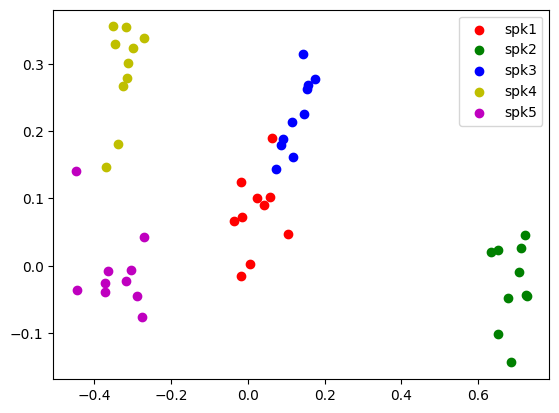

In [7]:
# TODO: perform PCA on the embeddings, visualize the embeddings for the first 5 speakers

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embedding_PCA = pca.fit_transform(all_embedding)

cmaps = ['r', 'g', 'b', 'y', 'm']

# plot the first 70 embeddings
for i in range(10):
    for j in range(5):
        plt.scatter(all_embedding_PCA[i+j*10][0], all_embedding_PCA[i+j*10][1], c=cmaps[j])
plt.legend(['spk'+str(i+1) for i in range(5)])
plt.show()

You should see that embeddings for different speakers are separate apart and each speaker has a cluster. For a query speaker utterance, we can compute its score with respect to all the speakers in the training utterances by calculating a similarity measure between the speaker embedding for this query utterance and all the average speaker embeddings. One of such similarity measure is **cosine similarity**, and let's apply it on our test set.

In [8]:
# TODO: calculate the cosine similarity scores between each utterance in the test set and all the average embeddings
# save your cosine similarity scores in cos_sim (shape: (50, 50) for (num_target_spk, num_test_utterance))

test_embedding = []

for i in range(len(test_audio)):
    this_spec = librosa.stft(test_audio[i].astype(np.float32), n_fft=512, hop_length=256)
    spec = torch.from_numpy(np.abs(this_spec))  # only use the magnitude spectrogram
    
    output, output_embedding = model(spec.unsqueeze(0).unsqueeze(1))
    test_embedding.append(output_embedding)
    
test_embedding = torch.cat(test_embedding, 0).data.numpy()  # 50, 256

cos_sim = np.dot(test_embedding, average_embedding.T) / np.sqrt(np.sum(average_embedding**2, 1)[:,np.newaxis] + 1e-6)

Now you have a 50*50 matrix of all the cosine similarity scores. Let's visualize it as a confusion matrix.

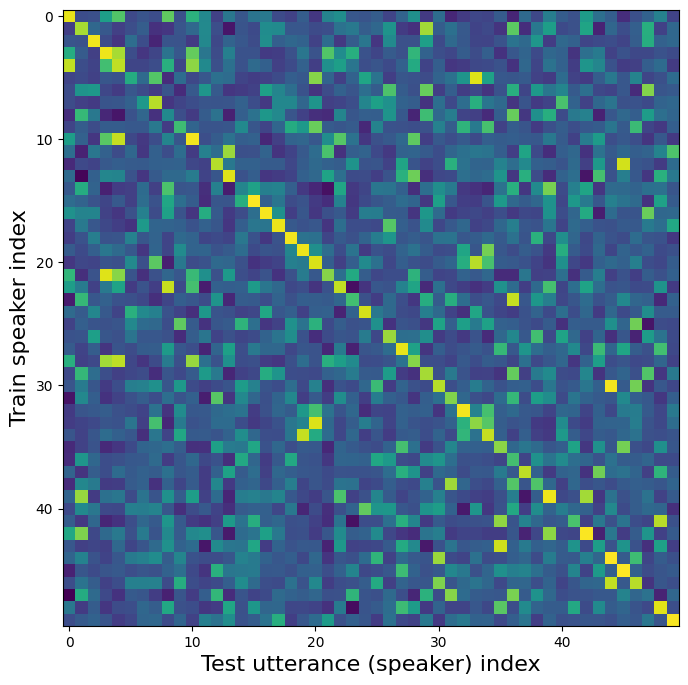

In [9]:
# visualize the cosine similarity scores as a confusion matrix

# this is the most simple way to plot it
plt.figure(figsize=(8,8))
plt.imshow(cos_sim)
plt.xlabel('Test utterance (speaker) index', fontsize=16)
plt.ylabel('Train speaker index', fontsize=16)
plt.show()

You may observe that for a successfull speaker recognition, the elements on the diagonal typically present the highest score for each test utterance. This is indeed what we expect.

Now we need a way to properly evaluate our system. We had the classification accuracy above which can be used for the identification task where we assume that we know all the target speakers to be identified in advance. For verification task which is indeed a binary classification task (accept/reject), we need other ways to determine the threshold for the similarity scores as well as measure the system's performance. One widely-used metric for evaluation in the verification task is the ***equal error rate (EER)***, defined as a value when [Type I = Type II error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors). It can be derived from the [***receiver operating characteristic (ROC) curve***](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics). I will not go into the details here and you can refer to the links for further information as well as its usage. A sample implementation of EER is directly provided here.

In [10]:
# EER calculation with ROC curve
# adopted from https://yangcha.github.io/EER-ROC/

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def EER(y, y_pred):
    # y_pred is a list of similarity scores for the verification task (cosine similarity values)
    # y is a list of the binary labels (accept/reject), where 1 is used for acceptance
    fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
    
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    decision_threshold = interp1d(fpr, threshold)(eer)
    
    return eer, decision_threshold

# example usage on the test utterances
# verify if each test utterance matches each of the target speakers
# a total of 50*50=2500 verification tasks

label = np.diag(np.ones(50)).reshape(-1).astype(np.float32)
eer, decision_threshold = EER(label, cos_sim.reshape(-1))
print('Overall EER: {:.2f}%; decision threshold for similarity scores: {:.2f}'.format(eer*100, decision_threshold))

Overall EER: 12.00%; decision threshold for similarity scores: 0.25


## 5. Siamese Network and Triplet Loss

What we have implemented above is an example pipeline - we train a standard multiclass classification system, use the feature as speaker embeddings, and identify (classify) or verify (score) them for the two tasks. However, there are other ways that we can train the model. Here we introduce another pipeline called ***siamese network and triplet loss***.

Let's first take a look at this illustration (https://levelup.gitconnected.com/metric-learning-using-siamese-and-triplet-convolutional-neural-networks-ed5b01d83be3).

![](https://miro.medium.com/max/1400/1*MIPdyhJGx6uLiob9UI9S0w.png)

We have three input images in this illustration. The term ***siamese network*** corresponds to the design that all three input images share the same network (same architecture and same parameters), and the term ***triplet loss*** corresponds to the training objective function applied to the three inputs. The three inputs, $x_a$, $x_p$ and $x_n$, represent the ***a*nchor input**, ***p*ositive sample**, and the ***n*egative sample**, respectively. In our case of speaker recognition, the anchor input is an utterance from a random speaker A, the positive sample is another utterance from the same speaker A, and the negative sample is an utterance from a random speaker B different from A. 

The triplet loss tries to **maximize** the similarity between the anchor input and the positive sample, and to **minimize** the similarity between the anchor input and the negative sample. The $\alpha$ term is a predefined nonnegative scalar determining the minimum margin of the difference between the two similarity scores. In our case of speaker recognition where cosine similarity is used for the similarity score, it is equivalent to the following objective:
$$\theta_{a,p} > \theta_{a,n} + \alpha$$
where $\theta$ corresponds to the cosine similarity. The triplet loss can then be written as:
$$L_{triplet} = max(\theta_{a,n} - \theta_{a,p} + \alpha , 0)$$

When $\theta_{a,p} > \theta_{a,n} + \alpha$, $max(\theta_{a,n} - \theta_{a,p} + \alpha , 0) = 0$ and there's no gradient with respect to the cosine similarity scores. This means that the negative and positive samples are already separated enough and no further optimization is required. When $\theta_{a,p} \leq \theta_{a,n} + \alpha$, $max(\theta_{a,n} - \theta_{a,p} + \alpha , 0) = \theta_{a,n} - \theta_{a,p} + \alpha$, and gradient descent on $L_{triplet}$ will minimize $\theta_{a,n}$ and maximize $\theta_{a,p}$. Given that the range of the cosine similarity scores are [-1, 1], let's empirically set $\alpha=1$ in our experiment.

Note that the difference between our loss and the loss in the illustration comes from the use of the **distance measure** $d(\cdot)$ instead of a **similarity measure** in the illustration. If we use a distance measure here (e.g. Euclidean distance), then the loss needs to be modified accordingly.

Now let's implement this triplet loss and add it to the original cross entropy loss. You need to write a new data loading function as we need one random positive sample and one negative sample for each of the anchor input in the training set. You can do something like:
- Sample another batch of data for the triplet loss:
    - Sample two speaker indices (e.g. speaker 2 and speaker 6).
    - Sample two utterances from the first speaker (e.g speaker 2) to form the anchor input and the positive sample, and sample one utterance from the second speaker (speaker 6) to form the negative sample.
    - Generate the speaker embeddings for the selected utterances, calculate cosine similarity and the triplet loss.

Note that the validation stage also makes use of the randomly sampled utterances for triplet loss. If you want to use a fixed set of triplet input samples, you can predefine a set of speaker and utterance indices shared by all epochs.

In [11]:
# TODO: train another network with triplet loss

model_siamese = AlexNet()

def sample_triplet(mode='train'):
    
    if mode == 'train':
        sample_num = 10
        dataset = train_audio
    elif mode == 'val':
        sample_num = 3
        dataset = val_audio
        
    # sample two speaker indices
    spk_idx = np.random.choice(50, 2, replace=False)
    
    # for the first speaker, sample two utterance indices
    # each speaker has 10 utterance for training
    anchor_idx, positive_idx = np.random.choice(sample_num, 2, replace=False)
        
    # for the second speaker, sample one utterance index
    negative_idx = np.random.choice(sample_num)
        
    # load the utterances
    anchor_utterance = dataset[spk_idx[0]*sample_num+anchor_idx]
    positive_utterance = dataset[spk_idx[0]*sample_num+positive_idx]
    negative_utterance = dataset[spk_idx[1]*sample_num+negative_idx]
        
    # calculate STFT
    anchor_spec = librosa.stft(anchor_utterance.astype(np.float32), n_fft=512, hop_length=256)
    positive_spec = librosa.stft(positive_utterance.astype(np.float32), n_fft=512, hop_length=256)
    negative_spec = librosa.stft(negative_utterance.astype(np.float32), n_fft=512, hop_length=256)
    anchor_spec = torch.from_numpy(np.abs(anchor_spec))
    positive_spec = torch.from_numpy(np.abs(positive_spec))
    negative_spec = torch.from_numpy(np.abs(negative_spec))
    
    return anchor_spec, positive_spec, negative_spec

# triplet loss
def triplet_loss(theta_ap, theta_an, alpha=1):
    # theta_ap shape: (batch,)
    # theta_an shape: (batch,)
    
    loss = F.relu(theta_an - theta_ap + alpha)
    
    return loss.mean()


def train(model, epoch, versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode. Always do this before you start training!
    train_loss = 0.
    
    # load batch data
    for batch_idx, data in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        # triplet loss
        batch_anchor_spec = []
        batch_positive_spec = []
        batch_negative_spec = []
        for j in range(batch_size):
            anchor_spec, positive_spec, negative_spec = sample_triplet(mode='train')
            batch_anchor_spec.append(anchor_spec.unsqueeze(0))
            batch_positive_spec.append(positive_spec.unsqueeze(0))
            batch_negative_spec.append(negative_spec.unsqueeze(0))
            
        batch_anchor_spec = torch.cat(batch_anchor_spec, 0)
        batch_positive_spec = torch.cat(batch_positive_spec, 0)
        batch_negative_spec = torch.cat(batch_negative_spec, 0)
        
        # get the embeddings
        _ , anchor_embedding = model(batch_anchor_spec.unsqueeze(1))
        _ , positive_embedding = model(batch_positive_spec.unsqueeze(1))
        _ , negative_embedding = model(batch_negative_spec.unsqueeze(1))
        
        # calculate cosine similarity scores
        theta_ap = (anchor_embedding * positive_embedding).sum(1)
        theta_an = (anchor_embedding * negative_embedding).sum(1)
        
        # triplet loss
        loss = triplet_loss(theta_ap, theta_an)
        
        # automatically calculate the backward pass
        loss.backward()
        # perform the actual backpropagation
        optimizer.step()
        
        train_loss += loss.data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | triplet loss {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | triplet loss {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss

def validate(model, epoch):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode. Always do this during validation or test phase!
    validation_loss = 0
    
    # load batch data
    for batch_idx, data in enumerate(validation_loader):
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass to save time and memory
        with torch.no_grad():
        
            # triplet loss
            batch_anchor_spec = []
            batch_positive_spec = []
            batch_negative_spec = []
            for j in range(batch_size):
                anchor_spec, positive_spec, negative_spec = sample_triplet(mode='val')
                batch_anchor_spec.append(anchor_spec.unsqueeze(0))
                batch_positive_spec.append(positive_spec.unsqueeze(0))
                batch_negative_spec.append(negative_spec.unsqueeze(0))

            batch_anchor_spec = torch.cat(batch_anchor_spec, 0)
            batch_positive_spec = torch.cat(batch_positive_spec, 0)
            batch_negative_spec = torch.cat(batch_negative_spec, 0)

            # get the embeddings
            _ , anchor_embedding = model(batch_anchor_spec.unsqueeze(1))
            _ , positive_embedding = model(batch_positive_spec.unsqueeze(1))
            _ , negative_embedding = model(batch_negative_spec.unsqueeze(1))

            # calculate cosine similarity scores
            theta_ap = (anchor_embedding * positive_embedding).sum(1)
            theta_an = (anchor_embedding * negative_embedding).sum(1)

            # triplet loss
            loss = triplet_loss(theta_ap, theta_an)
            
            validation_loss += loss.data.numpy()
        
    validation_loss = validation_loss / (batch_idx+1)
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | triplet loss {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_loss))
    print('-' * 99)
    
    return validation_loss


total_epoch = 100  # train the model for 100 epochs
model_save = 'best_AlexNet_siamese.pt'  # path to save the best validation model
optimizer = optim.Adam(model_siamese.parameters(), lr=1e-3)

# main function

training_loss = []
validation_loss = []

for epoch in range(1, total_epoch + 1):
    training_loss.append(train(model_siamese, epoch))
    validation_loss.append(validate(model_siamese, epoch))
    
    if training_loss[-1] == np.min(training_loss):
        print('      Best training model found.')
    if validation_loss[-1] == np.min(validation_loss):
        # save current best model on validation set
        with open(model_save, 'wb') as f:
            torch.save(model_siamese.state_dict(), f)
            print('      Best validation model found and saved.')
    
    print('-' * 99)

| epoch   1 |    15/   63 batches | ms/batch 372.44 | triplet loss 0.7626 |
| epoch   1 |    30/   63 batches | ms/batch 378.46 | triplet loss 0.6842 |
| epoch   1 |    45/   63 batches | ms/batch 377.93 | triplet loss 0.6255 |
| epoch   1 |    60/   63 batches | ms/batch 376.96 | triplet loss 0.6457 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time: 23.67s | triplet loss 0.6406 |
    | end of validation epoch   1 | time:  3.22s | triplet loss 0.5436 |
---------------------------------------------------------------------------------------------------
      Best training model found.
      Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |    15/   63 batches | ms/batch 389.32 | triplet loss 0.6535 |
| epoch   2 |    30/   63 batches | ms/batch 387.67 | triplet loss 0.5929 |
| epoch   2 |    45/  

After you finish the model training, evaluate your model by calculating the EER for the verification test. Compare the EER between the multiclass classification model and thie siamese network with triplet loss. What do you find? How can you improve the performance of the model with the worse performance?

In [14]:
# TODO: evaluate the model, calculate EER as above, and make the comparison
# remember to re-generate the average embeddings and the test embeddings

# load the best model on validation set
model_siamese.load_state_dict(torch.load('best_AlexNet_siamese.pt'))
model_siamese.eval()

all_embedding = []

for i in range(len(train_audio)):
    this_spec = librosa.stft(train_audio[i].astype(np.float32), n_fft=512, hop_length=256)
    spec = torch.from_numpy(np.abs(this_spec))  # only use the magnitude spectrogram
    
    _, output_embedding = model_siamese(spec.unsqueeze(0).unsqueeze(1))
    all_embedding.append(output_embedding)
    
all_embedding = torch.cat(all_embedding, 0).data.numpy()  # 500, 256
average_embedding = np.mean(all_embedding.reshape(50, 10, -1), 1)  # 50, 256

test_embedding = []

for i in range(len(test_audio)):
    this_spec = librosa.stft(test_audio[i].astype(np.float32), n_fft=512, hop_length=256)
    spec = torch.from_numpy(np.abs(this_spec))  # only use the magnitude spectrogram
    
    output, output_embedding = model_siamese(spec.unsqueeze(0).unsqueeze(1))
    test_embedding.append(output_embedding)
    
test_embedding = torch.cat(test_embedding, 0).data.numpy()  # 50, 256

cos_sim = np.dot(test_embedding, average_embedding.T) / np.sqrt(np.sum(average_embedding**2, 1)[:,np.newaxis] + 1e-6)
print(cos_sim.shape)
eer, decision_threshold = EER(label, cos_sim.reshape(-1))
print('Overall EER: {:.2f}%; decision threshold for similarity scores: {:.2f}'.format(eer*100, decision_threshold))

(50, 50)
Overall EER: 18.00%; decision threshold for similarity scores: 0.69


In [13]:
# TODO: enter your observations and comments

## Discussion: Conventional Speaker Recognition Systems

Prior to neural networks, the most popular methods for speaker recognition are [**Joint Factor Analysis (JFA)**](https://www.researchgate.net/profile/Patrick_Kenny/publication/228922248_Joint_factor_analysis_of_speaker_and_session_variability_Theory_and_algorithms/links/00b49519e4362ef144000000/Joint-factor-analysis-of-speaker-and-session-variability-Theory-and-algorithms.pdf) and [**i-vector**](https://ieeexplore.ieee.org/abstract/document/5545402). 

The general idea of these two methods is straightforward. Both methods attempt to present *all possible speech utterances* in a shared embedding space (like a Gaussian Mixture Model) - you can imagine that it is a generative model such that by assigning proper sampling strategies you can obtain speech utterances from different speakers. The embedding space contains everything including phonemes, pitch, and speaker identity, and for each utterance you have different weights applied to the embeddings of each of these characteristics, and this embedding space requires a training step with available data (like when we train the networks). The weight for the speaker identity characteristic is used as the speaker embeddings that distinguish different speakers. During model training, similar approaches can be applied like what we do here - we can still train a classifier such that speaker embeddings from the utterances from the same speaker are close to each other, and embeddings from the utterances from the different speakers are far from each other. This is typically done by Bayesian approaches.

Compared with the neural network approach, the embedding space is replaced by the mapping function defined by the neural network - we assume that the neural network itself is a strong enough feature extractor that only cares about the speaker identity and *removes* all the other characteristics in a given utterance. JFA and i-vector are both linear models and their performance can be constrained due to the model capacity, while the nonlinearity of the neural networks can better model the large amount of data and have a better representation and feature extraction power.

## Discussion: Scoring Method

We are using the most simple way of scoring with cosine similarity score. However, the most widely-used method for scoring is [***probabilistic linear discriminant analysis (PLDA)***](https://towardsdatascience.com/probabilistic-linear-discriminant-analysis-plda-explained-253b5effb96). PLDA is a probablistic framework that estimates the probability that a given speaker embedding belongs to the target speaker's speaker embeddings (like a GMM). For the details of how to apply PLDA scoring, you can check [this paper](https://ieeexplore.ieee.org/document/7078610) or [this implementation](https://github.com/RicherMans/PLDA).